<a href="https://colab.research.google.com/github/katyamineeva/person-detection-from-aerial-drone/blob/master/synthetic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Synthetic datasets creation

Note that this notebook is adapted to Google.Colab usege.

## Loading required libs, modules, models and datasets


In [1]:
import os
import sys
import random
import math
import numpy as np
from numpy.random import randint
import skimage.io
from skimage import img_as_float, img_as_uint, img_as_int
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import plot_model
import itertools
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
import pickle
import shutil
from IPython.display import clear_output
import csv
import cv2

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')


Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Local modules loading



In [0]:
sys.path.append('/content/drive/My Drive/project')
from utils_main_project.local_paths import *
from utils_main_project.saving_loading import *
from utils_main_project.visualization import *
from utils_main_project.global_constants import *

sys.path.append(paths['mask-rcnn-tf'])

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.utils import extract_bboxes
from samples.coco import coco

### Functions for trained Mask R-CNN  and MS COCO dataset loading

In [0]:
def load_trained_mrcnn():        
    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
        
    logs_dir = os.path.join(paths['mask-rcnn-tf'], 'logs')
    model = modellib.MaskRCNN(mode="inference", model_dir=logs_dir, config=InferenceConfig())
    
    weights_path = os.path.join(paths['mask-rcnn-tf'], 'mask_rcnn_coco.h5')
    model.load_weights(weights_path, by_name=True)
    return model

def load_coco():
    dataset = coco.CocoDataset()
    dataset.load_coco(paths['coco'], "val")
    dataset.prepare()
    return dataset


### Content of paths dictionary

In [0]:
print_paths_dict(paths, 'paths')

## Algorithms for cropping people

###  Сropped persons filtering and processing

In [0]:
def is_person_id_coco(class_id):
    return class_id == PERSON_CLASS_ID_COCO

def person_detected(class_ids_detected):
    for class_id in class_ids_detected:
        if is_person_id_coco(class_id):
            return True
    return False

def person_is_too_small(shape):
    h = max(shape[0], shape[1])
    w = min(shape[0], shape[1])
    return ((h <= MIN_PERSON_HEIGHT) or (w <= MIN_PERSON_WIDTH))

def person_is_not_full_body(shape):
    h = max(shape[0], shape[1])
    w = min(shape[0], shape[1])
    return not (MIN_PERSON_RATIO <= h / w <= MAX_PERSON_RATIO)

def model_rejects(model, image):
    r = model.detect([image], verbose=0)[0]
    for class_id, score in zip(r['class_ids'], r['scores']):
        if is_person_id_coco(class_id) and score > 0.95:
            return False
    return True

def person_is_too_big(shape):
    h = max(shape[0], shape[1])
    w = min(shape[0], shape[1])
    return ((h > MAX_PERSON_HEIGHT) or (w > MAX_PERSON_WIDTH))

def downsample_image_n_mask(image, mask):
    shape = mask.shape
    
    ratio_h = max(shape[0], shape[1]) / PERFECT_PERSON_HEIGHT
    ratio_w = min(shape[0], shape[1]) / PERFECT_PERSON_WIDTH
    ratio = max(ratio_h, ratio_w)
    new_shape = (int(shape[0] / ratio), int(shape[1] / ratio))

    image = skimage.transform.resize(image, (*new_shape, 3))
    mask = np.round(skimage.transform.resize(mask, new_shape))
    
    return image, mask


### Functions for cropping people from an images

In [0]:
def crop_person(image, mask, model_filter=False, model=None):
    not_empty_i = (mask.sum(axis=0) > 0)
    not_empty_j = (mask.sum(axis=1) > 0)
    cropped_shape = (sum(not_empty_j), sum(not_empty_i))

    if person_is_too_small(cropped_shape) or person_is_not_full_body(cropped_shape):
        return

    squared_mask = np.full(mask.shape, True)
    squared_mask = ((squared_mask * not_empty_i).T * not_empty_j).T                

    masked_person = image * mask.reshape(*mask.shape, -1)
    cropped_person = masked_person[squared_mask].reshape(*cropped_shape, -1)
    cropped_mask = mask[squared_mask].reshape(cropped_shape)
    
    if model_filter and model_rejects(model, cropped_person):
        return

    if person_is_too_big(cropped_shape):
        cropped_person, cropped_mask = downsample_image_n_mask(cropped_person, cropped_mask)        

    if skimage.exposure.is_low_contrast(cropped_person):
        return
        
    return cropped_person, cropped_mask


def crop_people_from_image(image, cnt_generated, class_ids, mask, output_path, model_filter=False, model=None):
    cropped_images_path = output_path + '/images'
    if (not os.path.exists(cropped_images_path)):
        os.mkdir(cropped_images_path)
        
    cropped_masks_path = output_path + '/masks'
    if (not os.path.exists(cropped_masks_path)):
        os.mkdir(cropped_masks_path)

    for ind, class_id in enumerate(class_ids):
        if is_person_id_coco(class_id):
            person_mask = mask[: , : , ind]     
            crop_result = crop_person(image, person_mask, model_filter, model)
            
            if crop_result != None:
                cropped_person, cropped_mask = crop_result
                cnt_generated += 1
                save_object_pickle(cropped_mask, cropped_masks_path, mask_id2filename(cnt_generated))
                save_image(cropped_person, cropped_images_path, image_id2filename(cnt_generated))
    return cnt_generated


### Function for cropping people using Mask R-CNN predictions

In [0]:
def model_crops_people_from_dataset(dataset_path, output_path, number_to_generate=2400, display_progress=False):
    if (not os.path.exists(output_path)):
        os.mkdir(output_path)

    model = load_trained_mrcnn()

    cnt_generated = 0
    for path in get_files_paths_list(dataset_path):
        image = skimage.io.imread(path)
        r = model.detect([image], verbose=0)[0]
        cnt_generated = crop_people_from_image(image, cnt_generated, r['class_ids'], r['masks'], output_path, model_filter=True, model=model)

        if display_progress and (cnt_generated % 10) == 0:
            clear_output()
            print("generated", cnt_generated)
        if cnt_generated > number_to_generate:
            return 


### Function for cropping people from COCO dataset using masks from dataset

In [0]:
def crop_people_from_coco(output_path, number_to_generate=3000, model_filter=False, display_progress=False):
    if (not os.path.exists(output_path)):
        os.mkdir(output_path)    
    
    dataset = load_coco()
    if model_filter:
        model = load_trained_mrcnn()
    else:
        model = None
    
    cnt_generated = 0    
    for image_id in dataset.image_ids:
        try:
            image = dataset.load_image(image_id)
            mask, class_ids = dataset.load_mask(image_id)
        except:
            continue
            
        cnt_generated = crop_people_from_image(image, cnt_generated, class_ids, mask, output_path, model_filter, model)

        if (display_progress):
            clear_output()
            print("generated", cnt_generated, "images")
        if cnt_generated > number_to_generate:
            return 

## Algorithm for synthetic data generation

### Generating non-intersecting locations for people on a background

In [0]:
def segments_intersect(l1, l2):
    l1, l2 = min(l1, l2), max(l1, l2)
    return (l1[0] <= l2[0] <= l1[1])

def rectangles_intersect(r1, r2):    
    h1 = (r1[1], r1[3])
    h2 = (r2[1], r2[3])
    
    v1 = (r1[0], r1[2])
    v2 = (r2[0], r2[2])
    
    return int(segments_intersect(h1, h2) and segments_intersect(v1, v2))

def there_are_intersections_in_prefix(rectangles, i):
    if len(rectangles) < 2:
        return False
    for j in range(i):
        if rectangles_intersect(rectangles[i], rectangles[j]):
            return True
    return False

    
def locate_cropped_people(background_shape, images_shapes):
    images_num = len(images_shapes)
    
    heights = images_shapes.T[0]
    widths = images_shapes.T[1]
    
    b_height = background_shape[0] - max(heights)
    b_width = background_shape[1] - max(widths)

    rectangles = np.zeros((images_num, 4), dtype=np.int)

    def generate_rectangle(i):
        rectangles[i][0] = randint(b_height)
        rectangles[i][1] = randint(b_width)
        rectangles[i][2] = rectangles[i][0] + heights[i]
        rectangles[i][3] = rectangles[i][1] + widths[i]
    
    def generate_locations(i):
        if i == images_num:
            return 0
        
        generate_rectangle(i)
        cnt_tries = 0
        while (there_are_intersections_in_prefix(rectangles, i)):
            generate_rectangle(i)
            cnt_tries += 1
            if cnt_tries > 10:
                generate_locations(i - 1)
        generate_locations(i + 1)
    
    generate_locations(0)
    return rectangles
   

### Synthetic data creation

In [0]:
def add_person_to_background(background, image, mask, location):
    mask = np.array(mask, dtype=np.uint8)

    b_shape = background.shape
    b_height, b_width, _ = b_shape
    m_shape = (b_height, b_width, 1)
    s_shape = (b_height, b_width)
    
    top, left = location
    img_height, img_width = mask.shape
    bottom, right = top + img_height, left + img_width
    
    squared_mask = np.full(s_shape, True)
    h_mask = (left <= np.arange(b_width)) * (np.arange(b_width) < right)
    v_mask = (top <= np.arange(b_height)) * (np.arange(b_height) < bottom)
    squared_mask *= h_mask
    squared_mask = (squared_mask.T * v_mask).T
    
    mask_extended = np.full(s_shape, 0, dtype=np.uint8)
    
    mask_extended[squared_mask] = mask.reshape(-1)
    mask_extended = mask_extended.reshape(m_shape)

    image_extended = np.full(b_shape, 0, dtype=np.uint8)
    image_extended[squared_mask] = image.reshape(-1, 3)
    image_extended = image_extended.reshape(b_shape)

    res = image_extended + (1 - mask_extended) * background
    return res, mask_extended
    
    
def create_sythetic_image(background_path, cropped_people_path, output_path, image_id):
    background = skimage.io.imread(background_path)
        
    created_images_path = output_path + '/images'
    if not os.path.exists(created_images_path):
        os.mkdir(created_images_path)
        
    created_masks_path = output_path + '/masks'
    if not os.path.exists(created_masks_path):
        os.mkdir(created_masks_path)
    
    people_num = randint(1, 5)
    people_ids = list(np.random.choice(image_ids_list(cropped_people_path), people_num))
    
    people_images, masks = get_images_n_masks(cropped_people_path,
                                              return_val='objects',
                                              return_iterator=False,
                                              ids=people_ids)
    
    people_shapes = np.array([[image.shape[0], image.shape[1]] for image in people_images])
        
    # top left coordinates
    people_bboxes = locate_cropped_people((background.shape[0], background.shape[1]), people_shapes)
    people_locations = np.stack((people_bboxes.T[0], people_bboxes.T[1])).T
    
    full_masks = []
    for image, mask, location in zip(people_images, masks, people_locations):
        background, full_mask = add_person_to_background(background, image, mask, location)
        full_masks.append(full_mask)
        
    save_image(background, created_images_path, image_id2filename(image_id))
    save_object_pickle(full_masks, created_masks_path, mask_id2filename(image_id))
    save_bboxes(people_bboxes, output_path, image_id)
    
    

def create_sythetic_dataset(cropped_people_path, output_path, number_to_generate='unlimited', display_progress=False):
    if (not os.path.exists(output_path)):
        os.mkdir(output_path)
    cnt_generated = 0
    for backgrounds_path in get_subdirs_paths_list(paths['backgrounds']):       
        for background_path in get_files_paths_list(backgrounds_path):
            create_sythetic_image(background_path, cropped_people_path, output_path, cnt_generated)
            cnt_generated += 1
            if (display_progress and (cnt_generated % 50 == 0)):
                clear_output()
                print("generated", cnt_generated, "images")
                
            if (number_to_generate != 'unlimited') and (cnt_generated > number_to_generate):
                return

## Launch creation of synthetic images based on VisDrone2018 dataset

Cropping people form VisDrone2018

In [0]:
source_path = paths['visdrone'] + '/images'
output_path = paths['visdrone_cropped_people']

model_crops_people_from_dataset(source_path, output_path, display_progress=True)

Generation of synthetic dataset

In [0]:
cropped_people_path = paths['visdrone_cropped_people']
output_path = paths['visdrone_synthetic_images']

create_sythetic_dataset(cropped_people_path, output_path, number_to_generate=800, display_progress=True)

## Launch creation of synthetic data images based on MS COCO dataset

Cropping people from COCO

In [0]:
output_path = paths['coco_cropped_people']
crop_people_from_coco(output_path, model_filter=True, number_to_generate=500)

Synthetic images generation

In [17]:
cropped_people_path = paths['coco_cropped_people']
output_path = paths['coco_synthetic_images']

create_sythetic_dataset(cropped_people_path, output_path, number_to_generate=800, display_progress=True)

generated 800 images


# Model testing on synthetic data

In [0]:
def init_gt_bbox(id, bbox):
    [y, x, y2, x2] = bbox
    gt_bb = BoundingBox(imageName=str(id),
                        classId=str(PERSON_CLASS_ID_COCO),
                        x=x, y=y, w=x2, h=y2,
                        typeCoordinates=CoordinatesType.Absolute,
                        bbType=BBType.GroundTruth,
                        format=BBFormat.XYX2Y2)
    return gt_bb

def init_dt_bbox(id, bbox, score):
    [y, x, y2, x2] = bbox
    dt_bb = BoundingBox(imageName=str(id),
                        classId=str(PERSON_CLASS_ID_COCO),
                        x=x, y=y, w=x2, h=y2,
                        typeCoordinates=CoordinatesType.Absolute,
                        bbType=BBType.Detected,
                        classConfidence=score,
                        format=BBFormat.XYX2Y2)
    return dt_bb


def get_bboxes(model, dataset_path, display_progress=False, ids=None):
    bb = BoundingBoxes()
    gt_bboxes = load_bboxes(dataset_path)
    
    if ids == None:
        ids = image_ids_list(dataset_path)
    
    
    for id, image_path in get_ids_n_images(dataset_path, return_val='paths', ids=ids):
        image = skimage.io.imread(image_path)

        # ground truth
        for bbox in gt_bboxes[id]:
            bb.addBoundingBox(init_gt_bbox(id, bbox))
            
        # detections
        r = model.detect([image])[0]
        
        dt_bboxes = extract_bboxes(r['masks'])
        for class_id, bbox, score in zip(r['class_ids'], dt_bboxes, r['scores']):
            if is_person_id_coco(class_id):
                bb.addBoundingBox(init_dt_bbox(id, bbox, score))
                
        if display_progress and id % 50 == 0:
            clear_output()
            print(id, "images processed")
    return bb


def evaluate_model(bb, iou_tr=0.3):
    eval = Evaluator()
    metrics = eval.GetPascalVOCMetrics(bb, IOUThreshold=iou_tr)[0]
    
    print("AP: ", metrics['AP'])
    print('total positives:', metrics['total positives'])
    print('total TP:', metrics['total TP'])
    print('total FP:', metrics['total FP'])
    
    eval.PlotPrecisionRecallCurve(bb, IOUThreshold=iou_tr,
                                  method=MethodAveragePrecision.EveryPointInterpolation, 
                                  showAP=True, showInterpolatedPrecision=True) 
    return metrics       

## Testing Mask R-CNN on VisDrone synthetic data

In [0]:
bb1 = get_bboxes(load_trained_mrcnn(), paths['visdrone_synthetic_images'], display_progress=True)
mc1 = evaluate_model(bb1)
sAP = mc1['AP']

In [0]:
mc1 = evaluate_model(bb1, iou_tr=0.5)
sAP += mc1['AP']

In [0]:
mc1 = evaluate_model(bb1, iou_tr=0.75)
sAP += mc1['AP']
print('mAP:', sAP / 3)

## Testing Mask R-CNN on COCO synthetic data

In [0]:
bb2 = get_bboxes(load_trained_mrcnn(), paths['coco_synthetic_images'], display_progress=True)
mc2 = evaluate_model(bb2)

In [0]:
mc2 = evaluate_model(bb2, iou_tr=0.5)

In [0]:
mc2 = evaluate_model(bb2, iou_tr=0.75)

# Testing locations generation

This part is just to make sure that generated locations indeed don't intersect

In [0]:
def person_random_shape():
    w = randint(7, 12)
    h = randint(17, 25)
    if randint(2) == 0:
        return [w, h]
    return [h, w]

# n -- number of rectangels to be placed
# n is generated randomly within n_limits semi-interval
def test_locations_generation(n_limits=(5, 7), iter_num=1):
    n = randint(*n_limits)

    persons_shapes = np.array([person_random_shape() for i in range(n)])
    
    bh_limits = (np.array([30, 35]) * (1 + n / 10))
    bw_limits = (np.array([45, 55]) * (1 + n / 10))
    
    background_shape = (randint(*bh_limits), randint(*bw_limits))
    
    rectangles = locate_cropped_people(background_shape, persons_shapes)
    
    draw_rectangles(background_shape, rectangles)
    if n <= len(NAMED_COLORS):
        for i in range(n):
            rectangle = rectangles[i]
            (top, left, bottom, right) = rectangles[i]
            str1 = NAMED_COLORS[i] + ' rectangle:'
            str2 = "(top, left) = " + str((top, left))
            str3 = "(bottom, right)= " + str((bottom, right))
            print("{:20} {:<25} {:<25}".format(str1, str2, str3))
         

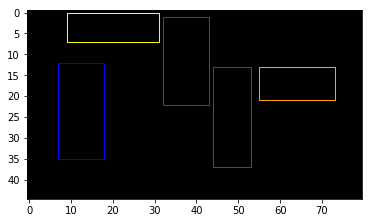

green rectangle:     (top, left) = (1, 32)     (bottom, right)= (22, 43)
red rectangle:       (top, left) = (13, 44)    (bottom, right)= (37, 53)
orange rectangle:    (top, left) = (13, 55)    (bottom, right)= (21, 73)
blue rectangle:      (top, left) = (12, 7)     (bottom, right)= (35, 18)
yellow rectangle:    (top, left) = (0, 9)      (bottom, right)= (7, 31) 


In [21]:
test_locations_generation()